# Sao Paulo's Housing Prices

### 1. Residential Properties for Sale in the City of Sao Paulo

Sao Paulo is the 8th most populous city on Earth and its metropolitan region, with over 30 million inhabitants, one of the largest urban agglomerations in the world. Its real estate market is a critical part of the economy and it has a huge impact on many aspects of life. In this notebook, you will find a comprehensive analysis of the residential properties for sale accross different neighborhoods. The purpose is to look for insights in the data and identify the key aspects that define housing prices in the geographic context.

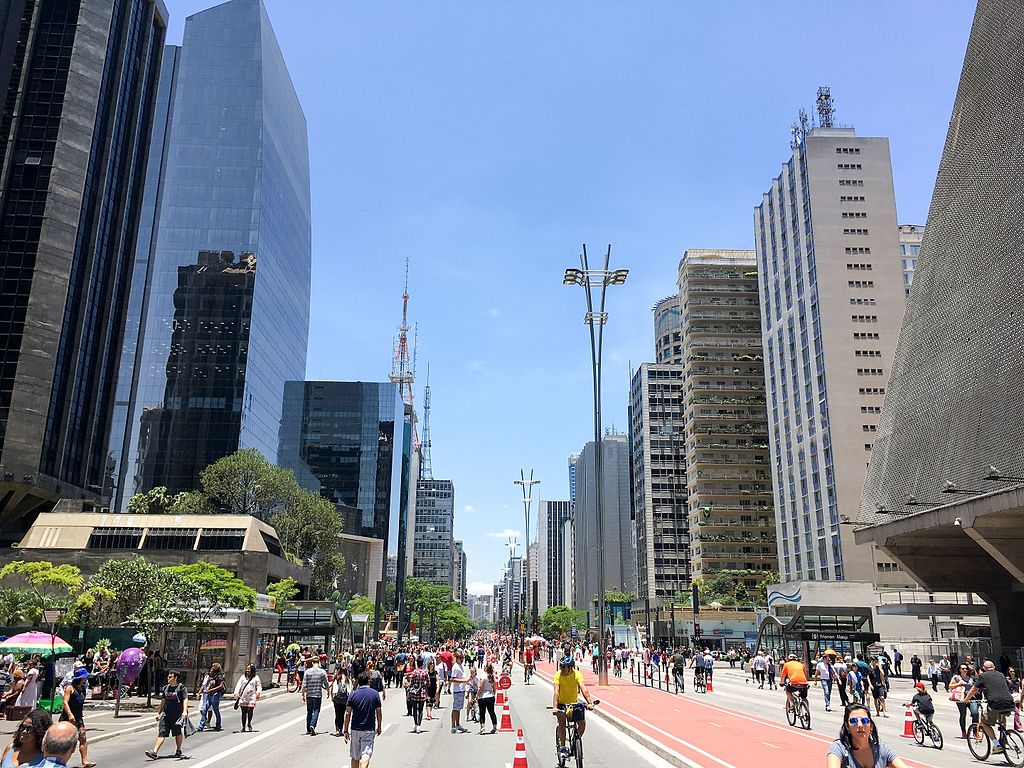

Let's take a look at the data, which consists of four files:
- **[Sao_Paulo.csv](https://www.kaggle.com/datasets/kaggleshashankk/house-price-data-of-sao-paulo):** contains a list of residential properties announced in the city.
- **enderecos.csv:** contains a complete list of streets, postcodes, latitudes and longitudes for all cities in Brazil.
- **Basico_SP.csv:** contains census demographic data of Sao Paulo gathered by the Brazilian Institute of Geography and Statistics (IBGE), in 2010.
- **SP_Setores_2020.shp**: contains geospatial polygons that identify the sectors investigated by the Brazilian Institute of Geography and Statistics (IBGE), in 2010.

In [25]:
# Import libraries and read in dataset
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

properties = pd.read_csv('/media/marianne/OS/Users/maria/Code/sp_housing/datasets/dados_imoveis.csv')
postcodes = pd.read_csv('/media/marianne/OS/Users/maria/Code/sp_housing/datasets/enderecos.csv')
demographics = pd.read_csv('/media/marianne/OS/Users/maria/Code/sp_housing/datasets/Basico_SP1.csv', encoding='ISO-8859-1', sep=';', thousands='.', decimal=',', usecols=[0, 14, 21, 22, 23, 25])
geoid = gpd.read_file('/media/marianne/OS/Users/maria/Code/sp_housing/datasets/SP_Setores_2020/SP_Setores_2020.shp')

/tmp/ipykernel_52710/2343216476.py:9: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  postcodes = pd.read_csv('/media/marianne/OS/Users/maria/Code/sp_housing/datasets/enderecos.csv')


## 2. Preparing and cleaning data




In [26]:
# Drop duplicates from properties
properties.drop_duplicates()

# Print the total number of residential properties
print('\nTotal number of properties announced in Sao Paulo dataset = ', len(properties.index))

# Dataset info
print(properties.info())

# Have a look at a random sample of 10 rows
properties.sample(10)


Total number of properties announced in Sao Paulo dataset =  10008
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10008 entries, 0 to 10007
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Rua        6574 non-null   object
 1   Bairro     9996 non-null   object
 2   Cidade     10008 non-null  object
 3   Metragem   10008 non-null  int64 
 4   Quartos    10008 non-null  int64 
 5   Banheiros  10008 non-null  int64 
 6   Vagas      10008 non-null  int64 
 7   Valor      10008 non-null  object
dtypes: int64(4), object(4)
memory usage: 625.6+ KB
None


,Rua,Bairro,Cidade,Metragem,Quartos,Banheiros,Vagas,Valor
2989,Rua Enrico de Martino,Jardim Leonor,São Paulo,475,4,5,6,R$ 1.600.000
3765,Rua Arandu,Brooklin Paulista,São Paulo,140,3,4,2,R$ 1.810.000
9784,Rua Diana,Perdizes,São Paulo,122,4,3,1,R$ 1.000.000
7026,Rua General Pereira da Cunha,Retiro Morumbi,São Paulo,2200,6,9,15,R$ 19.800.000
5322,Rua Santa Bibiana,Vila Sônia,São Paulo,255,3,4,6,R$ 1.100.000
3297,Rua Manduri,Jardim Paulistano,São Paulo,400,3,4,6,R$ 7.200.000
2975,Avenida Itacira,Planalto Paulista,São Paulo,1005,5,7,14,R$ 6.000.000
7485,"Rua Laplace, 962",Brooklin,São Paulo,634,5,4,4,R$ 2.800.000
2864,Rua Maria Carolina,Jardim Paulistano,São Paulo,600,3,5,4,R$ 9.500.000
8907,Rua Junqueira,Chácara Flora,São Paulo,1650,3,5,6,R$ 15.000.000


### properties df
By looking at a random sample of the dataset rows (from the above task), we observe that some entries in the columns like 'Rua' (address) and 'Bairro' (ward) may have null or inconsistent values (address with/without number), and that may impact the geographic generalization of the results. Also, the column 'Valor' (price) has special characters ('$', '.' , '/'), that may hinder future mathematical calculations.
Hence, the first step is to drop the rows without an address, and edit data into a consistent format, removing house numbers for identity protection. Then, we should confirm if any of the ward missing values can be filled based on entries with the same address values. Finally, we should remove the special characters in the 'Value' column.

In [27]:
# Keep rows with non-null addresses
prop_with_address = properties[properties['Rua'].notna()]

# Edit addresses into a consistant format
prop_with_address.loc['Rua'] = prop_with_address['Rua'].str.replace('\d+', '').str.replace(',', '').str.strip()

# Lookup addresses with ward missing values
prop_ward_missing = prop_with_address[prop_with_address['Bairro'].isna()]

# List of addresses with ward missing values
addresses = prop_ward_missing['Rua'].tolist()

# Lookup if missing values appear somewhere in the dataset
same_address = prop_with_address[prop_with_address['Rua'].isin(addresses)]

# Dictionary of missing values
same_address = same_address[same_address['Bairro'].notna()]
same_address = same_address.sort_values(['Rua', 'Bairro'])
full_address = dict(zip(same_address.Rua, same_address.Bairro))
full_address['Rua Professor Lúcio Martins Rodrigues'] = 'Morumbi'   # As we could not find other properties at this address, we lookedup in google maps and added this entry manually
print(full_address)

# Fill in ward missing values based on dictionary references
prop_with_address.loc['Bairro'] = prop_with_address['Bairro'].fillna(prop_with_address['Rua'].apply(lambda x: full_address.get(x)))

# Split column 'Valor'
prop_with_address[['Moeda', 'Valor_Anuncio', 'Tipo_Anuncio']] = prop_with_address['Valor'].str.split(expand=True)

# Filter properties for sale - rentals contain values 'per month/per year' in the column 'Tipo_Anuncio', therefore we will only keep null entries.
sale_properties = prop_with_address[prop_with_address['Tipo_Anuncio'].isna()]

# Convert 'Prices' format from string to float
sale_properties["Valor_BRL"] = sale_properties["Valor_Anuncio"].str.replace(".","").astype(float)

# Config display to suppress decimal cases and scientific notation of floats
pd.set_option("display.precision", 2)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Keep columns relevants to the project
sale_properties = sale_properties.drop(['Valor', 'Moeda', 'Valor_Anuncio', 'Tipo_Anuncio'], axis=1)

# Checking entries and dtypes
sale_properties.sample(10)

{'Rua Vergueiro': 'Vila Firmiano Pinto', 'Rua Professor Lúcio Martins Rodrigues': 'Morumbi'}


/tmp/ipykernel_52710/2459152452.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  prop_with_address.loc['Rua'] = prop_with_address['Rua'].str.replace('\d+', '').str.replace(',', '').str.strip()
/tmp/ipykernel_52710/2459152452.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prop_with_address.loc['Rua'] = prop_with_address['Rua'].str.replace('\d+', '').str.replace(',', '').str.strip()
/tmp/ipykernel_52710/2459152452.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prop_with_address.loc['Bairro'] = prop_with_address['Bairro'].fillna(prop_with_address['Rua'].apply

,Rua,Bairro,Cidade,Metragem,Quartos,Banheiros,Vagas,Valor_BRL
7660,Rua Alphonsus de Guimaraens,Santana,São Paulo,255.00,2.00,3.00,5.00,1200000.00
7007,"Rua Edson, ****",Campo Belo,São Paulo,204.00,3.00,5.00,3.00,1800000.00
4611,Rua Caritianas,Vila Monumento,São Paulo,183.00,3.00,4.00,3.00,1190000.00
7291,Avenida Santo Amaro,Brooklin Paulista,São Paulo,95.00,2.00,2.00,1.00,545000.00
2183,Rua Feliciano Maia,Jardim Paulista,São Paulo,305.00,3.00,2.00,3.00,3950000.00
7128,Rua Brigadeiro Gama Barcelos,Parque Jabaquara,São Paulo,350.00,3.00,4.00,4.00,800000.00
5204,"Rua Inácio Manuel Álvares, 886",Jardim Ester,São Paulo,178.00,3.00,4.00,5.00,770000.00
4030,"Rua Rino Levi, 70",Jardim da Glória,São Paulo,236.00,3.00,5.00,3.00,2100000.00
8324,Rua Pedro Teixeira,Vila Olímpia,São Paulo,135.00,3.00,3.00,1.00,1300000.00
1581,Rua José de Freitas Guimarães,Pacaembu,São Paulo,400.00,3.00,4.00,5.00,2600000.00


### postcodes df


In [28]:
# Have a look at a random sample of 10 rows
print(postcodes.sample(10))

# Filter postcodes of Sao Paulo
postcodes_sp = postcodes.query("nome_localidade == 'São Paulo'")

# Drop duplicates
postcodes_sp.drop_duplicates()

# Format addresses to enable join
postcodes_sp['rua'] = postcodes_sp['tipo_logr'] + ' ' + postcodes_sp['logr_nome']
postcodes_sp['rua'] = postcodes_sp['rua'].str.title().str.strip()
postcodes_sp.head()

# Keep columns relevant to the project
postcodes_sp = postcodes_sp.drop(['tipo_logr', 'logr_nome', 'logr_compl', 'numero', 'nome_localidade', 'sigla_uf'], axis=1)

# Rename columns to improve data legibility
postcodes_sp.columns = ['Bairro', 'CEP', 'Latitude', 'Longitude', 'Rua']
postcodes_sp.info(10)

        tipo_logr                 logr_nome  \
841473       Beco               da Roberval   
1103490       Rua  Professor Jaime Paladini   
764912        Rua           Santa Margarida   
27572    Travessa                   Guarimã   
976832        Rua          Olavo Bilac, 620   
845272    Avenida    Belmiro de Albuquerque   
458445        Rua         Francisco Rinaldi   
576750        Rua   João Rodrigues da Veiga   
968028        Rua           Antonio Codarim   
75060      Quadra        QR 206 Conjunto 15   

                                logr_compl numero  \
841473                    Beco da Roberval    NaN   
1103490       Rua Professor Jaime Paladini    NaN   
764912   Rua Santa Margarida - até 758/759    NaN   
27572                     Travessa Guarimã    NaN   
976832                Rua Olavo Bilac, 620    NaN   
845272      Avenida Belmiro de Albuquerque    NaN   
458445               Rua Francisco Rinaldi    NaN   
576750         Rua João Rodrigues da Veiga    NaN   
96802

/tmp/ipykernel_52710/536657150.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  postcodes_sp['rua'] = postcodes_sp['tipo_logr'] + ' ' + postcodes_sp['logr_nome']
/tmp/ipykernel_52710/536657150.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  postcodes_sp['rua'] = postcodes_sp['rua'].str.title().str.strip()


### demographics df

In [29]:
# Have a look at a random sample of 10 rows
print(demographics.sample(10))

# Drop invalid entry column
demographics.dropna(how='all', axis=1, inplace=True)

# Rename columns to improve data legibility
demographics.columns = ['CD_SETOR', 'DISTRITO', 'DOMICILIOS', 'MORADORES_SETOR', 'MORADORES_DOMICILIO', 'RENDA_MENSAL']

demographics.sample(10)

             Cod_setor Nome_do_distrito   V001   V002  V003    V005
4475   355030826000108       CONSOLAÇÃO 105.00 173.00  1.65 4532.33
5805   355030831000095       GUAIANASES 143.00 509.00  3.56  863.78
780    355030808000019            BELÉM 126.00 329.00  2.61 2197.40
14810  355030876000314        SAPOPEMBA 242.00 777.00  3.21 1042.27
6690   355030836000071   ITAIM PAULISTA 219.00 761.00  3.47  677.45
9483   355030847000065   JOSÉ BONIFÁCIO 289.00 927.00  3.21 1157.98
11068  355030858000193         PEDREIRA 195.00 578.00  2.96  988.93
5221   355030830000120           GRAJAÚ 258.00 867.00  3.36  522.83
10371  355030854000009          MORUMBI  84.00 237.00  2.82 5162.62
5618   355030830000565           GRAJAÚ  59.00 197.00  3.34  690.47


,CD_SETOR,DISTRITO,DOMICILIOS,MORADORES_SETOR,MORADORES_DOMICILIO,RENDA_MENSAL
10052,355030851000045,MANDAQUI,267.00,757.00,2.84,2003.76
11584,355030861000030,PERUS,102.00,482.00,4.73,790.33
15868,355030883000016,VILA ANDRADE,342.00,1039.00,3.04,6145.21
5975,355030832000094,MOEMA,219.00,572.00,2.61,11094.57
17957,355030894000233,VILA SÔNIA,142.00,410.00,2.89,8253.84
5625,355030830000574,GRAJAÚ,1.00,4.00,4.00,1300.00
8435,355030843000237,JARDIM ÂNGELA,495.00,1789.00,3.61,562.27
1677,355030813000227,CACHOEIRINHA,66.00,236.00,3.58,1092.12
6869,355030836000250,ITAIM PAULISTA,254.00,890.00,3.50,628.22
6826,355030836000207,ITAIM PAULISTA,124.00,437.00,3.52,668.50


### geoid df

In [30]:
# Have a look at a random sample of 10 rows
print(geoid.sample())

# Filter geospatial polygons that belong to the city of Sao Paulo
geoid_sp = geoid[geoid.NM_MUN == "São Paulo"]

# Filter columns relevant to the project
geoid_sp = geoid_sp.drop(['CD_SIT', 'NM_SIT', 'CD_UF', 'NM_UF', 'SIGLA_UF', 'CD_MUN', 'CD_DIST', 'CD_SUBDIST', 'NM_SUBDIST'], axis=1)

# Convert column 'CD_SECTOR' data format from str to int
geoid_sp = geoid_sp.astype({'CD_SETOR':'int'})

# Validation
geoid_sp.head(10)

              CD_SETOR CD_SIT                                        NM_SIT  \
51936  354260205000017      1  Área Urbana de Alta Densidade de Edificações   

      CD_UF      NM_UF SIGLA_UF   CD_MUN    NM_MUN    CD_DIST   NM_DIST  \
51936    35  São Paulo       SP  3542602  Registro  354260205  Registro   

        CD_SUBDIST NM_SUBDIST  \
51936  35426020500       None   

                                                geometry  
51936  POLYGON ((-47.84097 -24.50345, -47.84095 -24.5...  


,CD_SETOR,NM_MUN,NM_DIST,geometry
65509,355030801000001,São Paulo,Água Rasa,"POLYGON ((-46.56954 -23.56918, -46.57016 -23.5..."
65510,355030801000002,São Paulo,Água Rasa,"POLYGON ((-46.56806 -23.56521, -46.56786 -23.5..."
65511,355030801000003,São Paulo,Água Rasa,"POLYGON ((-46.56619 -23.56605, -46.56632 -23.5..."
65512,355030801000004,São Paulo,Água Rasa,"POLYGON ((-46.56876 -23.56856, -46.56863 -23.5..."
65513,355030801000005,São Paulo,Água Rasa,"POLYGON ((-46.57121 -23.57005, -46.57056 -23.5..."
65514,355030801000007,São Paulo,Água Rasa,"POLYGON ((-46.57197 -23.57243, -46.57202 -23.5..."
65515,355030801000009,São Paulo,Água Rasa,"POLYGON ((-46.57359 -23.56831, -46.57364 -23.5..."
65516,355030801000010,São Paulo,Água Rasa,"POLYGON ((-46.57327 -23.56550, -46.57191 -23.5..."
65517,355030801000011,São Paulo,Água Rasa,"POLYGON ((-46.56960 -23.56560, -46.57107 -23.5..."
65518,355030801000012,São Paulo,Água Rasa,"POLYGON ((-46.56886 -23.56462, -46.56873 -23.5..."


## 3. Joining the DataFrames

In [31]:
# Merge properties and postcodes
property_codes = sale_properties.merge(postcodes_sp, on=['Rua', 'Bairro'])

# Drop duplicates from properties
property_codes.drop_duplicates()

# Have a look at a random sample of 10 rows
print(property_codes.sample(10))

# Merge demographics and geoids
geo_stats = geoid_sp.merge(demographics, on = 'CD_SETOR')

# Have a look at a random sample of 10 rows
print(geo_stats.sample(10))

                                Rua                Bairro     Cidade  \
3555                  Rua Itanhandu       Vila Leopoldina  São Paulo   
2915       Rua Doutor João Pinheiro       Jardim Paulista  São Paulo   
3880                    Rua Potenji          Vila Mariana  São Paulo   
4731                  Rua Guararema       Bosque da Saúde  São Paulo   
5115  Rua Domingos Osvaldo Bataglia          Mirandópolis  São Paulo   
4249           Avenida Lasar Segall          Vila Celeste  São Paulo   
4131                 Alameda Franca       Jardim Paulista  São Paulo   
60              Rua Nicolau Barreto         Vila Cordeiro  São Paulo   
4945                   Rua Marituba  Chácara Monte Alegre  São Paulo   
2655              Rua Alberto Hodge           Santo Amaro  São Paulo   

      Metragem  Quartos  Banheiros  Vagas  Valor_BRL        CEP  Latitude  \
3555    168.00     3.00       3.00   2.00 1300000.00 5319040.00    -23.54   
2915    457.00     5.00       6.00   3.00 6500000.00 

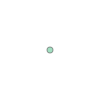

In [32]:
from shapely.geometry import Point
latitude = -23.56 	
longitude = -46.59
Point(longitude, latitude)

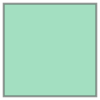

In [33]:
from shapely.geometry import Polygon
Polygon([[0, 0], [1, 0], [1, 1], [0, 1], [0, 0]])



In [34]:
Polygon([[0, 0], [1, 0], [1, 1], [0, 1], [0, 0]]).contains(Point(0.1,0.9))

True

In [35]:
# Define point by geographic coordinates
property_codes['Point'] = ''
for i in property_codes.index:
    property_codes['Point'][i] = Point(property_codes['Longitude'][i], property_codes['Latitude'][i])

# Map 
property_codes['setor_censo'] = property_codes["Point"].map(lambda x: geoid.loc[geoid.contains(x), 'CD_SETOR'].values).str[0]
property_codes.sample(10)

/tmp/ipykernel_52710/506561733.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  property_codes['Point'][i] = Point(property_codes['Longitude'][i], property_codes['Latitude'][i])


KeyboardInterrupt: 

In [ ]:
# Save df to csv
property_codes.to_csv('/media/marianne/OS/Users/maria/Code/sp_housing/datasets/property_codes.csv')

In [ ]:
# Read full csv file
merged_data = pd.read_csv('/media/marianne/OS/Users/maria/Code/sp_housing/datasets/property_codes.csv')
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5439 entries, 0 to 5438
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   5439 non-null   int64  
 1   Rua          5439 non-null   object 
 2   Bairro       5439 non-null   object 
 3   Cidade       5439 non-null   object 
 4   Metragem     5439 non-null   float64
 5   Quartos      5439 non-null   float64
 6   Banheiros    5439 non-null   float64
 7   Vagas        5439 non-null   float64
 8   Valor_BRL    5439 non-null   float64
 9   CEP          5439 non-null   float64
 10  Latitude     5439 non-null   float64
 11  Longitude    5439 non-null   float64
 12  Point        5439 non-null   object 
 13  setor_censo  5435 non-null   float64
dtypes: float64(9), int64(1), object(4)
memory usage: 595.0+ KB


## 4. Exploring property types

In [36]:
# Find Average Home Floor Size
merged_data.Metragem.mean()

472.43592572164

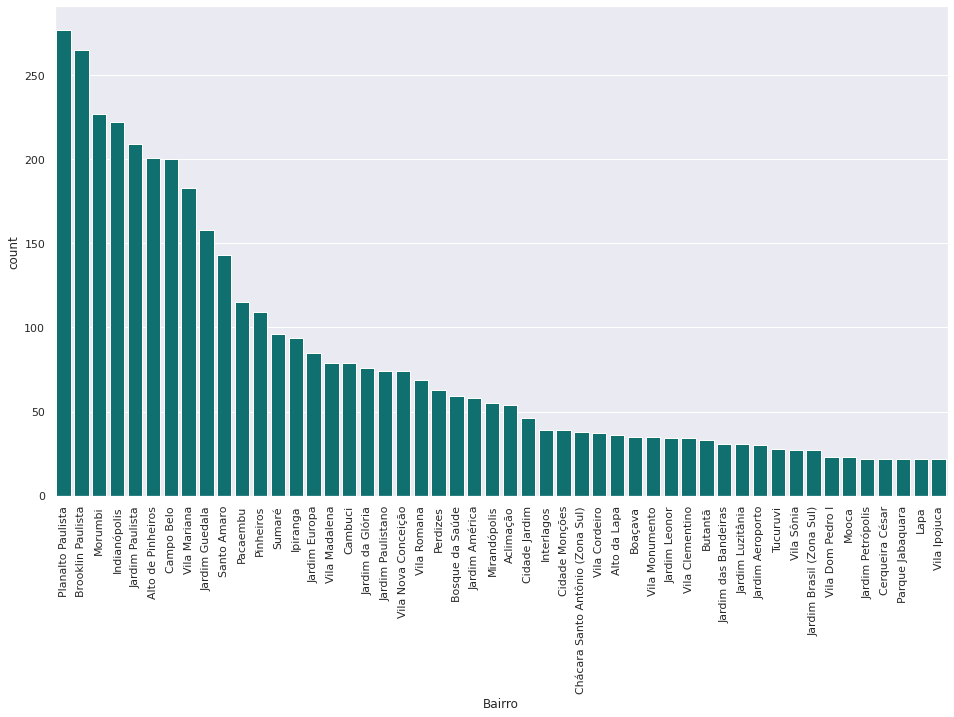

In [46]:
# Property Announcements per District
sns.set()
plt.figure(figsize=(16,9))
ax = sns.countplot(x="Bairro", data=merged_data, order=merged_data.Bairro.value_counts().iloc[:50].index, color='teal')
ax.tick_params(axis='x', rotation=90)
plt.show()

<AxesSubplot:title={'center':'Área Média dos Imóveis por Bairro de São Paulo'}, xlabel='Bairro'>

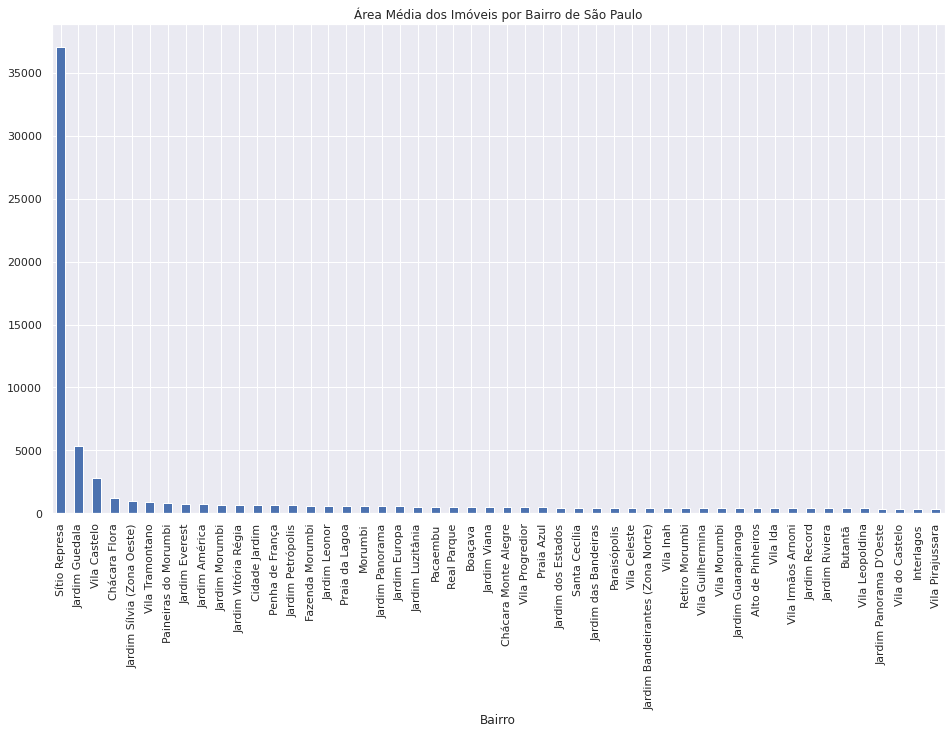

In [37]:
#2. Área média dos imóveis por bairro (amostra sem tratamento)

amedia_bairro = merged_data.groupby("Bairro")["Metragem"].mean()
mbairro_sorted = amedia_bairro.sort_values(ascending=False)
plt.figure(figsize=(16,9))
mbairro_sorted.head(50).plot.bar(title="Área Média dos Imóveis por Bairro de São Paulo")

In [47]:
# Outlier Search: huge properties
huge_properties = merged_data.sort_values("Metragem", ascending=False)
huge_properties.head(10)

,Unnamed: 0,Rua,Bairro,Cidade,Metragem,Quartos,Banheiros,Vagas,Valor_BRL,CEP,Latitude,Longitude,Point,setor_censo
379,379,Avenida George Saville Dodd,Jardim Guedala,São Paulo,750000.00,5.00,9.00,6.00,7000000.00,5608020.00,-23.58,-46.71,POINT (-46.7073838 -23.5827571),355030854000008.00
4584,4584,Rua Benedito Felizardo,Sítio Represa,São Paulo,37000.00,4.00,2.00,4.00,2900000.00,4894050.00,-23.86,-46.76,POINT (-46.7577805 -23.8596706),355030855000401.00
3919,3919,Rua Canuto Borelli,Vila Castelo,São Paulo,2850.00,3.00,3.00,10.00,4000000.00,4438070.00,-23.68,-46.67,POINT (-46.6710252 -23.6803339),355030816000264.00
4713,4713,Rua Itassuce,Pacaembu,São Paulo,2505.00,3.00,7.00,12.00,12500000.00,1234040.00,-23.97,-46.37,POINT (-46.3692932 -23.9713783),355100905000545.00
4714,4714,Rua Itassuce,Pacaembu,São Paulo,2505.00,3.00,7.00,12.00,12500000.00,1234040.00,-23.97,-46.37,POINT (-46.3692932 -23.9713783),355100905000545.00
4712,4712,Rua Itassuce,Pacaembu,São Paulo,2500.00,3.00,7.00,12.00,12500000.00,1234040.00,-23.97,-46.37,POINT (-46.3692932 -23.9713783),355100905000545.00
4469,4469,Rua Estados Unidos,Jardim América,São Paulo,1816.00,4.00,10.00,20.00,55000000.00,1427001.00,-23.57,-46.67,POINT (-46.6682211 -23.5672586),355030845000276.00
4468,4468,Rua Estados Unidos,Jardim América,São Paulo,1816.00,4.00,10.00,20.00,55000000.00,1427000.00,-23.57,-46.67,POINT (-46.6682211 -23.5672586),355030845000276.00
4470,4470,Rua Estados Unidos,Jardim América,São Paulo,1816.00,4.00,10.00,20.00,55000000.00,1427002.00,-23.57,-46.67,POINT (-46.6682211 -23.5672586),355030845000276.00
2615,2615,Rua Brigadeiro Armando Trompowsky,Jardim Morumbi,São Paulo,1705.00,7.00,7.00,6.00,12000000.00,5655050.00,-23.61,-46.72,POINT (-46.7170576 -23.6106546),355030854000057.00


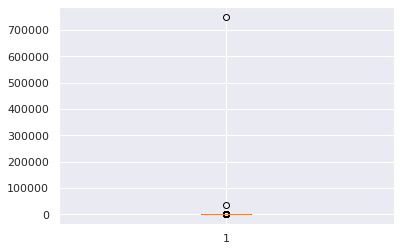

In [48]:
#4. Boxplot amostra sem tratamento
plt.boxplot(merged_data["Metragem"])
plt.show()

Conforme informações da [Prefeitura Municipal de São Paulo](https://gestaourbana.prefeitura.sp.gov.br/area-e-frente-maximas-de-lote/), a área máxima de lote no território da zona urbana do Município é de **20.000m²** e a frente máxima é de 150m, ambas podendo ser menores de acordo com a zona na qual o lote está inserido, sendo que essa área pode ser maior para alguns usos, por exemplo, clubes, cemitérios, parques dentre outros.
As áreas listadas nos imóveis nº 9845 e 6600 excedem esse valor, é pouco provável que estas se enquadrem no perfil da amostra.

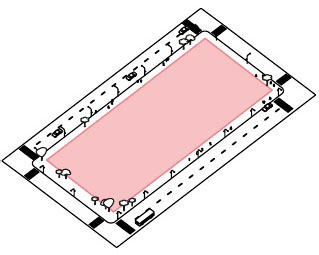

In [49]:
#5. Contextualização dos imóveis mais amplos em seus respectivos bairros - Amostra 9845
index_bairro = merged_data.set_index("Bairro")
index_jd_guedala = index_bairro.loc["Jardim Guedala"]
index_jd_guedala.Metragem.sort_values(ascending=False)

Bairro
Jardim Guedala   750000.00
Jardim Guedala     1400.00
Jardim Guedala     1225.00
Jardim Guedala     1225.00
Jardim Guedala      969.00
                    ...   
Jardim Guedala      325.00
Jardim Guedala      320.00
Jardim Guedala      280.00
Jardim Guedala      255.00
Jardim Guedala      250.00
Name: Metragem, Length: 158, dtype: float64

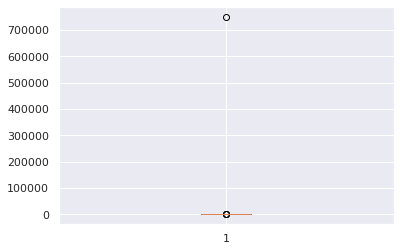

In [50]:
#6. Boxplot Jardim Guedala
plt.boxplot(index_jd_guedala["Metragem"])
plt.show()

In [51]:
#7. Amostra 6600
index_s_represa = index_bairro.loc["Sítio Represa"]
index_s_represa

Unnamed: 0                                4584
Rua                     Rua Benedito Felizardo
Cidade                               São Paulo
Metragem                              37000.00
Quartos                                   4.00
Banheiros                                 2.00
Vagas                                     4.00
Valor_BRL                           2900000.00
CEP                                 4894050.00
Latitude                                -23.86
Longitude                               -46.76
Point          POINT (-46.7577805 -23.8596706)
setor_censo                 355030855000401.00
Name: Sítio Represa, dtype: object

In [52]:
#8. Soma de imóveis anunciados no Bairro Sítio Represa
sum((merged_data.Bairro == "Sítio Represa"))

1

A amostra 6600 possui área total de 37.000m² e constitui o único imóvel anunciado no Bairro Sítio Represa. Por exceder a área de lote urbano máxima prevista pela prefeitura, e por não apresentar dados comparativos da vizinhança, também será desconsiderada.

In [53]:
#9. Amostra 7930
index_sto_amaro = index_bairro.loc["Santo Amaro"]
index_sto_amaro.Metragem.sort_values(ascending=False)

Bairro
Santo Amaro   1000.00
Santo Amaro    885.00
Santo Amaro    880.00
Santo Amaro    805.00
Santo Amaro    805.00
                ...  
Santo Amaro    110.00
Santo Amaro     42.00
Santo Amaro     42.00
Santo Amaro     37.00
Santo Amaro     37.00
Name: Metragem, Length: 143, dtype: float64

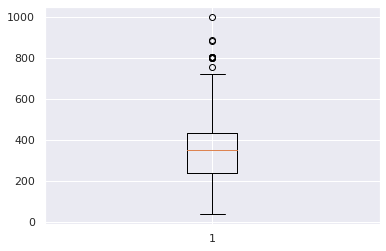

In [54]:
#10. Boxplot Santo Amaro
plt.boxplot(index_sto_amaro["Metragem"])
plt.show()

As amostras 9845 e 7930 serão desconsideradas por não corresponderem a construções de mesma tipologia residencial das demais que compõem o banco de dados, além de destoarem completamente de outros imóveis no mesmo bairro.

In [55]:
#11. Amostra 4788
index_v_castelo = index_bairro.loc["Vila Castelo"]
index_v_castelo

Unnamed: 0                                3919
Rua                         Rua Canuto Borelli
Cidade                               São Paulo
Metragem                               2850.00
Quartos                                   3.00
Banheiros                                 3.00
Vagas                                    10.00
Valor_BRL                           4000000.00
CEP                                 4438070.00
Latitude                                -23.68
Longitude                               -46.67
Point          POINT (-46.6710252 -23.6803339)
setor_censo                 355030816000264.00
Name: Vila Castelo, dtype: object

In [56]:
#12. Soma de imóveis anunciados no Bairro Vila Castelo 
sum((merged_data["Bairro"] == "Vila Castelo"))

1

In [57]:
#13. Amostras 7906, 7791, 7067
index_pacaembu = index_bairro.loc["Pacaembu"]
index_pacaembu.Metragem.sort_values(ascending=False)

Bairro
Pacaembu   2505.00
Pacaembu   2505.00
Pacaembu   2500.00
Pacaembu   1156.00
Pacaembu   1005.00
             ...  
Pacaembu    250.00
Pacaembu    230.00
Pacaembu    230.00
Pacaembu    196.00
Pacaembu    160.00
Name: Metragem, Length: 115, dtype: float64

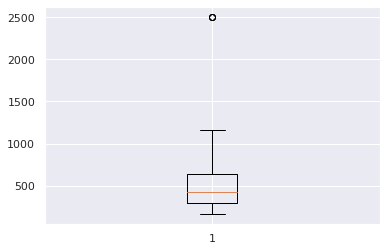

In [58]:
#14. Boxplot Pacaembu
plt.boxplot(index_pacaembu["Metragem"])
plt.show()

In [63]:
#17. Amostra 1936
index_tucuruvi = index_bairro.loc["Tucuruvi"]
index_tucuruvi.Metragem.sort_values(ascending=False)

Bairro
Tucuruvi   349.00
Tucuruvi   349.00
Tucuruvi   349.00
Tucuruvi   349.00
Tucuruvi   349.00
Tucuruvi   349.00
Tucuruvi   349.00
Tucuruvi   349.00
Tucuruvi   349.00
Tucuruvi   349.00
Tucuruvi   349.00
Tucuruvi   349.00
Tucuruvi   349.00
Tucuruvi   349.00
Tucuruvi   250.00
Tucuruvi   250.00
Tucuruvi   250.00
Tucuruvi   250.00
Tucuruvi   250.00
Tucuruvi   250.00
Tucuruvi   250.00
Tucuruvi   250.00
Tucuruvi   250.00
Tucuruvi   250.00
Tucuruvi   250.00
Tucuruvi   250.00
Tucuruvi   250.00
Tucuruvi   250.00
Name: Metragem, dtype: float64

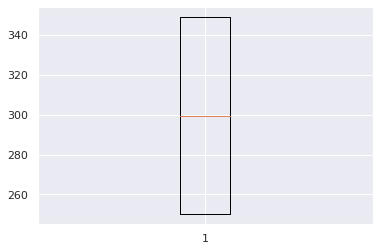

In [64]:
#18. Boxplot Tucuruvi
plt.boxplot(index_tucuruvi["Metragem"])
plt.show()

As amostras 4788, 7906, 7791, 7067, 6908, 7026, e 1936 dos Bairros Vila Castelo, Pacaembu, Retiro Morumbi e Tucuruvi possuem área superior a 2.000m². Este valor destoa um pouco dos imóveis no contexto da vizinhança, porém é possível encontrar imóveis de metragem semelhante em outros bairros da cidade. Assim, por ora, essas amostras serão mantidas.

In [65]:
#19. Busca de outliers: imóveis minusculos 
tiny_properties = merged_data.sort_values("Metragem")
tiny_properties.head(10)

,Unnamed: 0,Rua,Bairro,Cidade,Metragem,Quartos,Banheiros,Vagas,Valor_BRL,CEP,Latitude,Longitude,Point,setor_censo
5348,5348,Rua Pestana,Vila Guaca,São Paulo,10.00,3.00,2.00,2.00,800000.00,2433070.00,-23.54,-46.80,POINT (-46.802283 -23.5380917),353440105001765.00
3997,3997,Rua Marie Nader Calfat,Jardim Ampliação,São Paulo,20.00,3.00,2.00,2.00,800000.00,5713520.00,-23.63,-46.73,POINT (-46.7297799 -23.6277585),355030883000262.00
3999,3999,Rua Marie Nader Calfat,Jardim Ampliação,São Paulo,25.00,3.00,2.00,2.00,800000.00,5713520.00,-23.63,-46.73,POINT (-46.7297799 -23.6277585),355030883000262.00
3998,3998,Rua Marie Nader Calfat,Jardim Ampliação,São Paulo,25.00,3.00,2.00,2.00,800000.00,5713520.00,-23.63,-46.73,POINT (-46.7297799 -23.6277585),355030883000262.00
4705,4705,Rua Ipomeias,Vila Bela,São Paulo,36.00,2.00,1.00,1.00,196000.00,3201050.00,-23.60,-46.57,POINT (-46.5733783 -23.5990493),355030893000051.00
2616,2616,Rua Bela Vista,Santo Amaro,São Paulo,37.00,5.00,5.00,2.00,690000.00,4709000.00,-23.63,-46.69,POINT (-46.6921169 -23.6333885),355030871000263.00
4779,4779,Rua Sacadura Cabral,Lapa,São Paulo,37.00,1.00,2.00,1.00,510000.00,5076020.00,-23.52,-46.71,POINT (-46.7102663 -23.5212257),355030848000058.00
2617,2617,Rua Bela Vista,Santo Amaro,São Paulo,37.00,5.00,5.00,2.00,690000.00,4709001.00,-23.56,-46.65,POINT (-46.6463975 -23.5570827),355030807000013.00
4780,4780,Rua Sacadura Cabral,Lapa,São Paulo,42.00,1.00,2.00,1.00,510000.00,5076020.00,-23.52,-46.71,POINT (-46.7102663 -23.5212257),355030848000058.00
4781,4781,Rua Sacadura Cabral,Lapa,São Paulo,42.00,1.00,2.00,1.00,510000.00,5076020.00,-23.52,-46.71,POINT (-46.7102663 -23.5212257),355030848000058.00


In [ ]:
#20. Amostra 9603
index_v_guaca = index_bairro.loc["Vila Guaca"]
index_v_guaca

Rua          Rua Pestana
Cidade         São Paulo
Metragem              10
Quartos                3
Banheiros              2
Vagas                  2
Valor         R$ 800.000
Name: Vila Guaca, dtype: object

In [ ]:
#21. Soma de imóveis anunciados no Bairro Vila Guaca
sum((dados_bairro["Bairro"] == "Vila Guaca"))

1

A amostra 9603 é incrivelmente pequena, com 3 dormitórios acomodados em apenas 10m² é um imóvel impossível, por isso será desconsiderada.

In [ ]:
#22. Amostras 5009, 5059, 5652
index_jd_ampliacao = index_bairro.loc["Jardim Ampliação"]
index_jd_ampliacao.Metragem.sort_values(ascending=False)

Bairro
Jardim Ampliação    25
Jardim Ampliação    25
Jardim Ampliação    20
Name: Metragem, dtype: int64

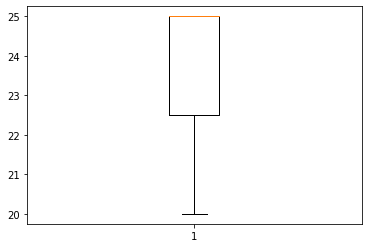

In [ ]:
#23. Boxplot Jardim Ampliação
plt.boxplot(index_jd_ampliacao["Metragem"])
plt.show()

As amostras 5009, 5059 e 5652 também são pouco prováveis, com 3 dormitórios em 20-25m², mas viáveis, em alguma tipologia residencial com cozinha compartilhada ou algo do gênero, mas não há dados suficientes para confirmação, por isso seus dados serão mantidos.

In [ ]:
#24. Filtragem de outliers defeituosos
dados_area = dados_bairro.drop([9845, 6600, 7930, 4788, 9603])
dados_area.Metragem.describe()

count    6568.000000
mean      335.114038
std       248.260121
min        20.000000
25%       165.000000
50%       263.500000
75%       425.000000
max      2505.000000
Name: Metragem, dtype: float64

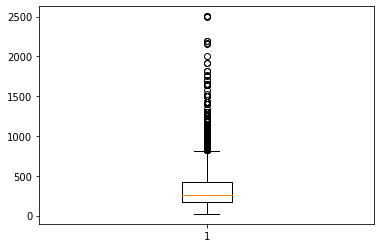

In [ ]:
#25. Boxplot da amostra tratada
plt.boxplot(dados_area["Metragem"])
plt.show()

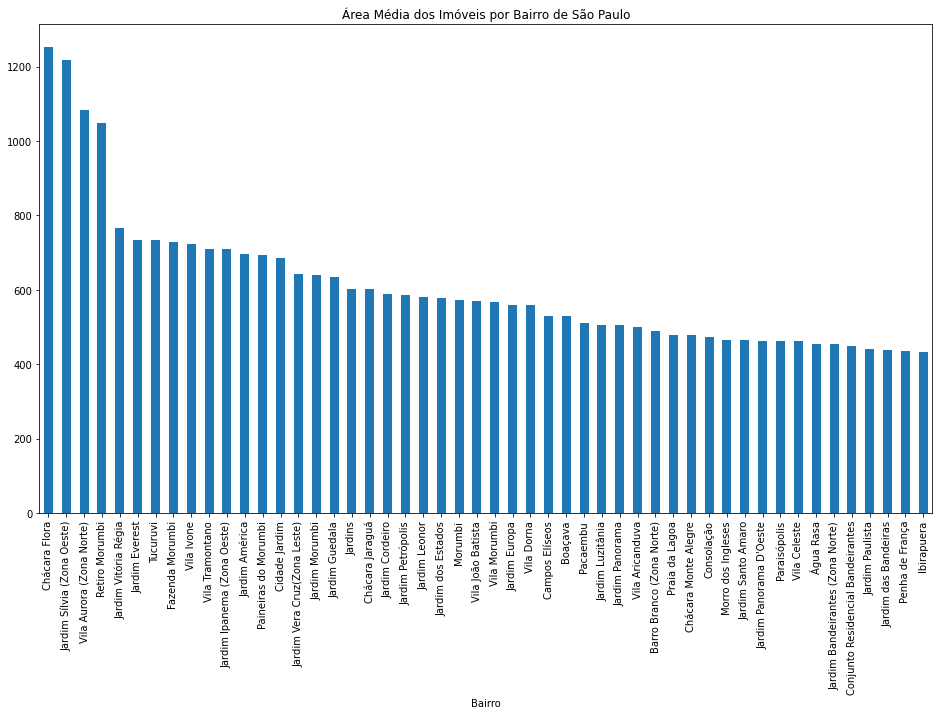

In [ ]:
#26. Área média dos imóveis por bairro (amostra tratada)
area_m_bairro = dados_area.groupby("Bairro")["Metragem"].mean()
area_m_bairro_sorted = area_m_bairro.sort_values(ascending=False)
plt.figure(figsize=(16,9))
area_m_bairro_sorted.head(50).plot.bar(title="Área Média dos Imóveis por Bairro de São Paulo")

## 5. Filter out "junk" properties

In [ ]:
dados_area.describe()

,Metragem,Quartos,Banheiros,Vagas
count,6568.000000,6568.000000,6568.000000,6568.000000
mean,335.114038,3.431486,3.758678,3.876218
std,248.260121,1.062618,1.849627,2.611671
min,20.000000,1.000000,1.000000,1.000000
25%,165.000000,3.000000,2.000000,2.000000
50%,263.500000,3.000000,4.000000,3.000000
75%,425.000000,4.000000,5.000000,5.000000
max,2505.000000,16.000000,14.000000,50.000000


In [ ]:
tipos_imoveis = dados_area.groupby(['Quartos','Banheiros', 'Vagas']).agg({'Metragem':'mean'})
tipos_imoveis

Metragem
Quartos Banheiros Vagas             
1       1         1       155.882353
                  2       115.307692
                  3       143.333333
                  4       232.200000
                  6       120.000000
...                              ...
11      6         10     1000.000000
        8         2       192.500000
                  10      350.000000
15      8         12      480.000000
16      3         3       282.500000

[393 rows x 1 columns]

<Figure size 1152x648 with 0 Axes>

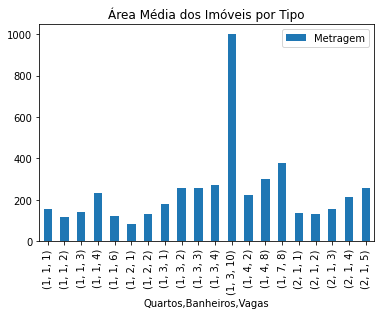

In [ ]:
plt.figure(figsize=(16,9))
tipos_imoveis.head(20).plot.bar(title="Área Média dos Imóveis por Tipo")
plt.show()

In [ ]:
dados_area["Quartos"].value_counts()

3     2900
4     2030
2      847
5      512
6      139
1       73
7       34
8       13
9        8
11       6
10       3
16       2
15       1
Name: Quartos, dtype: int64

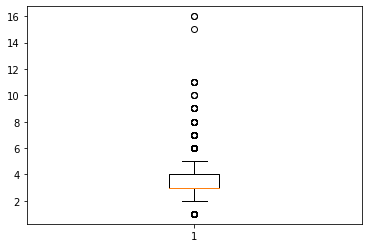

In [ ]:
plt.boxplot(dados_area["Quartos"])
plt.show()

In [ ]:
dados_area["Banheiros"].value_counts()

3     1387
2     1214
4     1197
5     1008
1      632
6      623
7      278
8      159
9       33
10      29
12       4
11       3
14       1
Name: Banheiros, dtype: int64

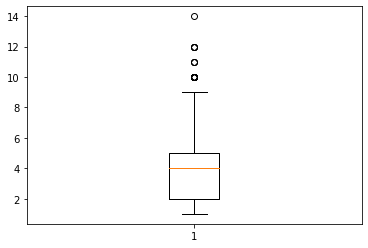

In [ ]:
plt.boxplot(dados_area["Banheiros"])
plt.show()

In [ ]:
dados_area["Vagas"].value_counts()

2     1729
4     1354
3     1032
6      648
1      592
5      544
8      264
10     156
7      118
12      46
9       35
15      11
14      10
20       9
16       5
13       4
25       3
50       2
11       2
18       1
38       1
30       1
24       1
Name: Vagas, dtype: int64

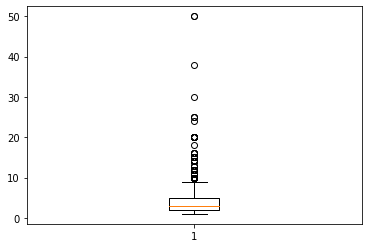

In [ ]:
plt.boxplot(dados_area["Vagas"])
plt.show()

In [ ]:
dados_quartos = dados_area.query("Quartos <= 6")
dados_quartos

,Rua,Bairro,Cidade,Metragem,Quartos,Banheiros,Vagas,Valor
0,Avenida Itacira,Planalto Paulista,São Paulo,1000,4,8,6,R$ 7.000.000
1,Rua Aurelia Perez Alvarez,Jardim dos Estados,São Paulo,496,4,4,4,R$ 3.700.000
2,Rua Alba Valdez,Jardim Reimberg,São Paulo,125,4,3,2,R$ 380.000
4,Rua Tobias Barreto,Mooca,São Paulo,100,3,2,2,R$ 540.000
5,Rua Graham Bell,Santo Amaro,São Paulo,440,4,4,6,R$ 1.980.000
...,...,...,...,...,...,...,...,...
10002,Avenida Odila,Planalto Paulista,São Paulo,267,3,6,4,R$ 1.500.000
10003,Rua Tapuçu,Vila Sofia,São Paulo,95,2,2,2,R$ 665.000
10005,Rua Estero Belaco,Vila da Saúde,São Paulo,205,3,3,6,R$ 1.050.000
10006,Rua Manuel Onha,Vila Oratório,São Paulo,185,3,2,2,R$ 2.200\n /Mês


In [ ]:
dados_banheiros = dados_quartos.query("Banheiros <= 9")
dados_banheiros

,Rua,Bairro,Cidade,Metragem,Quartos,Banheiros,Vagas,Valor
0,Avenida Itacira,Planalto Paulista,São Paulo,1000,4,8,6,R$ 7.000.000
1,Rua Aurelia Perez Alvarez,Jardim dos Estados,São Paulo,496,4,4,4,R$ 3.700.000
2,Rua Alba Valdez,Jardim Reimberg,São Paulo,125,4,3,2,R$ 380.000
4,Rua Tobias Barreto,Mooca,São Paulo,100,3,2,2,R$ 540.000
5,Rua Graham Bell,Santo Amaro,São Paulo,440,4,4,6,R$ 1.980.000
...,...,...,...,...,...,...,...,...
10002,Avenida Odila,Planalto Paulista,São Paulo,267,3,6,4,R$ 1.500.000
10003,Rua Tapuçu,Vila Sofia,São Paulo,95,2,2,2,R$ 665.000
10005,Rua Estero Belaco,Vila da Saúde,São Paulo,205,3,3,6,R$ 1.050.000
10006,Rua Manuel Onha,Vila Oratório,São Paulo,185,3,2,2,R$ 2.200\n /Mês


In [ ]:
dados_vagas = dados_banheiros.query("Vagas <= 10")
dados_vagas

,Rua,Bairro,Cidade,Metragem,Quartos,Banheiros,Vagas,Valor
0,Avenida Itacira,Planalto Paulista,São Paulo,1000,4,8,6,R$ 7.000.000
1,Rua Aurelia Perez Alvarez,Jardim dos Estados,São Paulo,496,4,4,4,R$ 3.700.000
2,Rua Alba Valdez,Jardim Reimberg,São Paulo,125,4,3,2,R$ 380.000
4,Rua Tobias Barreto,Mooca,São Paulo,100,3,2,2,R$ 540.000
5,Rua Graham Bell,Santo Amaro,São Paulo,440,4,4,6,R$ 1.980.000
...,...,...,...,...,...,...,...,...
10002,Avenida Odila,Planalto Paulista,São Paulo,267,3,6,4,R$ 1.500.000
10003,Rua Tapuçu,Vila Sofia,São Paulo,95,2,2,2,R$ 665.000
10005,Rua Estero Belaco,Vila da Saúde,São Paulo,205,3,3,6,R$ 1.050.000
10006,Rua Manuel Onha,Vila Oratório,São Paulo,185,3,2,2,R$ 2.200\n /Mês


In [ ]:
dados_tipo = dados_vagas.set_index(["Quartos", "Banheiros", "Vagas"])
dados_tipo.sort_index()

Rua             Bairro  \
Quartos Banheiros Vagas                                                      
1       1         1                 Rua Bernardo Vieira          Vila Laís   
                  1                        Rua Assungui    Vila Gumercindo   
                  1            Rua Professor Tranquilli       Vila Mariana   
                  1                      Rua Luís Botta  Cidade São Mateus   
                  1                          Rua Apicum       Vila Matilde   
...                                                 ...                ...   
6       7         10                    Rua Campo Verde      Jardim Europa   
                  10           Rua São José do Barreiro          Água Rasa   
                  10           Rua São José do Barreiro          Água Rasa   
        8         4      Rua Professor Eduardo Monteiro      Jardim Leonor   
                  6                     Avenida Morumbi            Morumbi   

                            Cidade  Metragem  \
Quartos Banheiros Vagas                        
1       1         1      São Paulo       104   
                  1      São Paulo       500   
                  1      São Paulo        60   
                  1      São Paulo        61   
                  1      São Paulo        90   
...                            ...       ...   
6       7         10     São Paulo       880   
                  10     São Paulo       800   
                  10     São Paulo       805   
        8         4      São Paulo       262   
                  6      São Paulo      1200   

                                                         Valor  
Quartos Banheiros Vagas                                         
1       1         1                                 R$ 270.000  
                  1      R$ 10.000\n                      /Mês  
                  1       R$ 2.100\n                      /Mês  
                  1                                 R$ 147.288  
                  1                                 R$ 350.000  
...                                                        ...  
6       7         10                             R$ 15.000.000  
                  10     R$ 15.000\n                      /Mês  
                  10     R$ 15.000\n                      /Mês  
        8         4                               R$ 1.295.000  
                  6                               R$ 8.500.000  

[6387 rows x 5 columns]

In [ ]:
dados_tipo.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 6387 entries, (4, 8, 6) to (3, 2, 2)
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Rua       6387 non-null   object
 1   Bairro    6387 non-null   object
 2   Cidade    6387 non-null   object
 3   Metragem  6387 non-null   int64 
 4   Valor     6387 non-null   object
dtypes: int64(1), object(4)
memory usage: 269.3+ KB


## 6. Geographic distribution

In [ ]:
#1. Número de amostras contidas no Bairro Vila Mariana
sum((dados["Bairro"] == "Vila Mariana"))

184

In [ ]:
#2. Máscara de filtragem de dados do Bairro Vila Mariana
bairro_vmariana = (dados.Bairro == "Vila Mariana")
bairro_vmariana

0        False
1        False
2        False
3        False
4        False
         ...  
10003    False
10004    False
10005    False
10006    False
10007    False
Name: Bairro, Length: 10008, dtype: bool

In [ ]:
#3. Subset da amostra contendo apenas imóveis do Bairro Vila Mariana
imoveis_vmariana = dados[bairro_vmariana]
imoveis_vmariana

,Rua,Bairro,Cidade,Metragem,Quartos,Banheiros,Vagas,Valor
100,Rua Pero Correia,Vila Mariana,São Paulo,250,3,3,1,R$ 1.350.000
120,Praça Doutor Carvalho Franco,Vila Mariana,São Paulo,250,3,5,2,R$ 2.450.000
155,Rua Professor João Marinho,Vila Mariana,São Paulo,170,3,4,2,R$ 1.490.000
160,NaN,Vila Mariana,São Paulo,228,4,5,3,R$ 2.200.000
334,"Rua Pero Correia, 892",Vila Mariana,São Paulo,350,6,4,10,R$ 1.700.000
...,...,...,...,...,...,...,...,...
9645,Rua Sousa Ramos,Vila Mariana,São Paulo,285,3,5,5,R$ 1.650.000
9701,Rua Benito Juarez,Vila Mariana,São Paulo,171,3,2,4,R$ 1.650.000
9737,Rua Benito Juarez,Vila Mariana,São Paulo,171,3,2,4,R$ 1.650.000
9807,NaN,Vila Mariana,São Paulo,275,3,1,6,R$ 1.500.000


In [ ]:
#4. Área média dos imóveis do Bairo Vila Mariana
imoveis_vmariana["Metragem"].mean()

233.6195652173913

## 7. Price per property type

In [ ]:
amedia_dorm = dados.groupby("Quartos")["Metragem"].agg([min, max, sum])
amedia_dorm

,min,max,sum
Quartos,,,
1,29,1000,20989
2,36,1105,185717
3,10,35677,1156581
4,64,37000,1567753
5,37,750000,1281219
6,120,2200,144239
7,200,7126,44383
8,160,1500,11179
9,137,950,4681


In [ ]:
dados.describe()

,Metragem,Quartos,Banheiros,Vagas
count,10008.000000,10008.000000,10008.000000,10008.000000
mean,442.300659,3.483114,3.879097,4.097222
std,7515.379389,1.064200,1.988467,2.824014
min,10.000000,1.000000,1.000000,1.000000
25%,173.000000,3.000000,2.000000,2.000000
50%,290.000000,3.000000,4.000000,4.000000
75%,460.250000,4.000000,5.000000,5.000000
max,750000.000000,16.000000,40.000000,50.000000


In [ ]:
dados.sort_values(["Metragem", "Quartos"], ascending=[False, True])

,Rua,Bairro,Cidade,Metragem,Quartos,Banheiros,Vagas,Valor
9845,Avenida George Saville Dodd,Jardim Guedala,São Paulo,750000,5,9,6,R$ 7.000.000
6600,Rua Benedito Felizardo,Sítio Represa,São Paulo,37000,4,2,4,R$ 2.900.000
6883,NaN,Jardim da Glória,São Paulo,35677,3,3,4,R$ 2.550.000
7930,"Rua Duque de Caxias, 298",Santo Amaro,São Paulo,7126,7,2,20,R$ 80.000\n /Mês
4788,Rua Canuto Borelli,Vila Castelo,São Paulo,2850,3,3,10,R$ 4.000.000
...,...,...,...,...,...,...,...,...
8553,Rua Barra da Jangada,Parada Inglesa,São Paulo,29,1,1,1,R$ 300.000
5059,Rua Marie Nader Calfat,Jardim Ampliação,São Paulo,25,3,2,2,R$ 800.000
5652,Rua Marie Nader Calfat,Jardim Ampliação,São Paulo,25,3,2,2,R$ 800.000
5009,Rua Marie Nader Calfat,Jardim Ampliação,São Paulo,20,3,2,2,R$ 800.000


In [ ]:
dados.sort_values("Valor", ascending=False)

,Rua,Bairro,Cidade,Metragem,Quartos,Banheiros,Vagas,Valor
3741,Rua Professor Brasil Machado de Campos,Jardim da Glória,São Paulo,230,5,4,3,R$ 999.999
6465,Rua Professor Sílvio de Sá e Silva,Parque São Domingos,São Paulo,296,5,5,3,R$ 999.900
8771,Rua Texas,Brooklin Paulista,São Paulo,120,3,1,3,R$ 999.000
7750,Rua Orlando Ferraiuolo,Vila Brasilina,São Paulo,340,3,2,3,R$ 999.000
8586,Rua Orlando Ferraiuolo,Vila Brasilina,São Paulo,345,3,2,3,R$ 999.000
...,...,...,...,...,...,...,...,...
4658,NaN,Chácara Santo Antônio (Zona Sul),São Paulo,105,3,2,2,R$ 1.000.000
4000,Rua Alberto Willo,Planalto Paulista,São Paulo,210,3,3,1,R$ 1.000.000
2019,Rua Artur Dias,Bosque da Saúde,São Paulo,126,3,5,3,R$ 1.000.000
4277,Rua Teodureto Souto,Cambuci,São Paulo,180,3,2,2,R$ 1.000.000


In [ ]:
dados["Bairro"]

0         Planalto Paulista
1        Jardim dos Estados
2           Jardim Reimberg
3            Jardim Morumbi
4                     Mooca
                ...        
10003            Vila Sofia
10004       Bosque da Saúde
10005         Vila da Saúde
10006         Vila Oratório
10007           Vila Alpina
Name: Bairro, Length: 10008, dtype: object

In [ ]:
amedia_dorm = dados.groupby("Quartos")["Metragem"].mean()
amedia_dorm

Quartos
1      196.158879
2      155.411715
3      274.526703
4      473.784527
5     1491.523865
6      664.695853
7      792.553571
8      558.950000
9      390.083333
10     622.750000
11     380.000000
12     523.500000
13     450.000000
15     480.000000
16     282.500000
Name: Metragem, dtype: float64

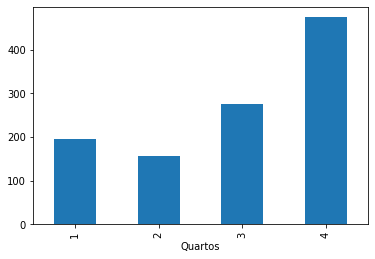

In [ ]:
amedia_dorm.head(4).plot.bar()

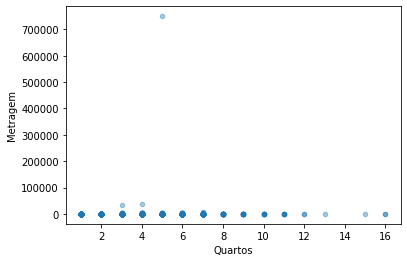

In [ ]:
dados.plot.scatter(x="Quartos", y="Metragem", alpha=0.4)

In [ ]:
a_min_max_soma_bairro["min"].sort_values(ascending=False)

NameError: ignored

In [ ]:
a_min_max_soma_bairro["max"].sort_values(ascending=False)

In [ ]:
a_min_max_soma_bairro["sum"].sort_values(ascending=False)

In [ ]:
dados.groupby("Bairro")["Metragem", "Quartos"].mean()

In [ ]:

sum((dados["Bairro"]=="Vila Mariana")*1)

In [ ]:
dados.pivot_table(values="Metragem", index="Quartos")

In [ ]:
dados.pivot_table(values="Metragem", index="Bairro", columns="Quartos", fill_value=0)

In [ ]:
tipo_imovel = dados.set_index(["Quartos", "Banheiros"])
tipo_imovel

In [ ]:
tipo_imovel.loc[3]

In [ ]:
tipo_imovel.sort_values(["Bairro"], ascending=False)

In [ ]:
#Desafio 5: Identificar quais bairros estão sem nome de rua
dados.isna().sum()

In [ ]:
ruas_faltantes = dados.Rua == "None"
ruas_faltantes

In [ ]:
dados[dados_zero]


In [ ]:
#9. Importação do matplotlib
from matplotlib import pyplot as plt

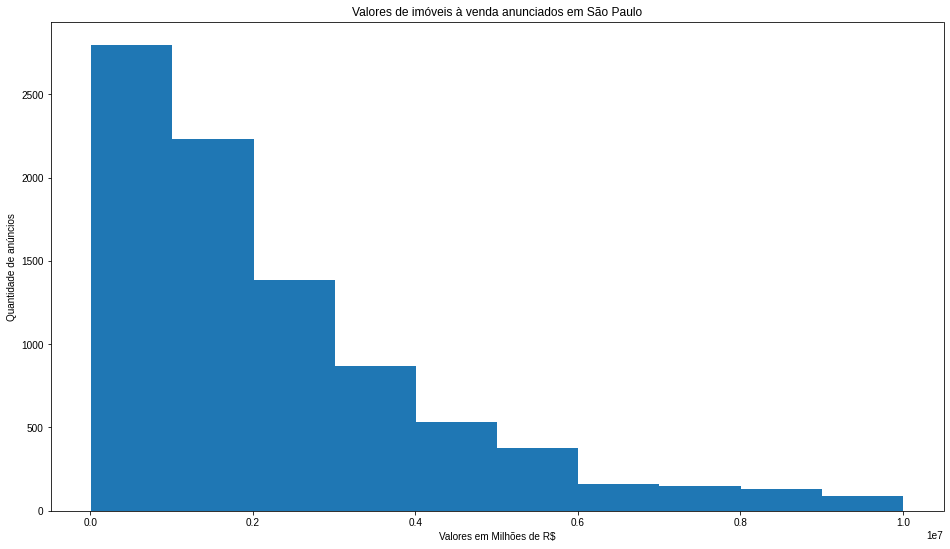

In [ ]:
#10. Valores dos imóveis
plt.figure(figsize=(16,9))
plt.hist(dados_vendas["Valor_float"], range=(10000, 10000000))
plt.title("Valores de imóveis à venda anunciados em São Paulo")
plt.xlabel("Valores em Milhões de R$")
plt.ylabel("Quantidade de anúncios")
plt.style.use('seaborn')
plt.show()

## 8. Price per location

In [ ]:
#Desafio 3: Preço do metro quadrado por bairro
import numpy as np
dados_vendas["Valor_mqd"] = dados_vendas["Valor_float"] / dados_vendas["Metragem"]
dados_vendas["Valor_mqd"].sort_values(ascending=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


3542   59282.02
6882   54166.67
1530   54166.67
7569   51635.11
102    48941.80
         ...   
559      764.25
5874     546.88
6398     542.64
60        65.00
11        34.40
Name: Valor_mqd, Length: 9151, dtype: float64

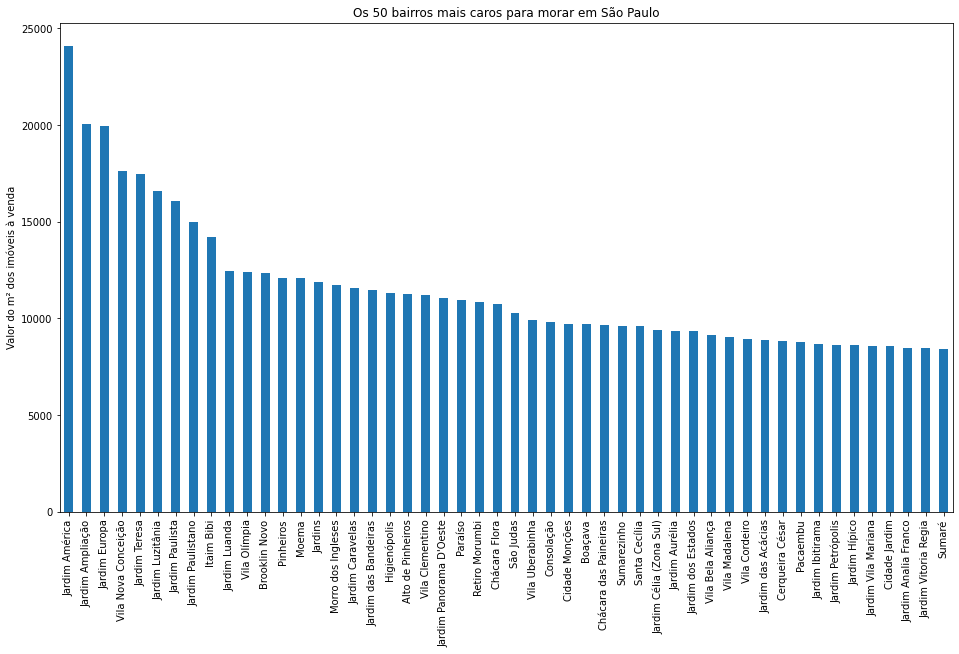

In [ ]:
#Desafio 3: Preço do metro quadrado por bairro
mqd_bairro = dados_vendas.groupby("Bairro")["Valor_mqd"].mean()
mqd_bairro_sorted = mqd_bairro.sort_values(ascending=False)
plt.figure(figsize=(16,9))
mqd_bairro_sorted.head(50).plot.bar(title="Os 50 bairros mais caros para morar em São Paulo", xlabel="", ylabel="Valor do m² dos imóveis à venda")

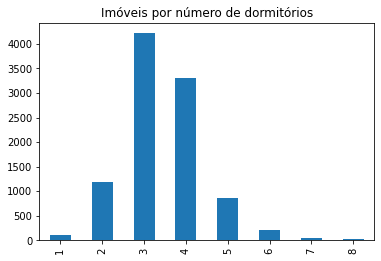

In [ ]:
imoveis_dorm = dados["Quartos"].value_counts()
dorm_sorted = imoveis_dorm.sort_index()
dorm_sorted.head(8).plot.bar(title="Imóveis por número de dormitórios")

In [ ]:
#Desafio 4: Conclusão - os bairros listados constituem o percentil 75% da amostra. O valor mediano do metro quadrado residencial na capital paulistana é de 6500 reais, sendo possível encontrar uma ampla gama de imóveis por um preço moderado, entre 4000-5000 reais por metro quadrado.
dados_vendas.describe()

,Metragem,Quartos,Banheiros,Vagas,Valor_float,Valor_mqd
count,9151.00,9151.00,9151.00,9151.00,9151.00,9151.00
mean,344.44,3.45,3.80,3.96,3051985.60,7999.53
std,249.55,1.05,1.97,2.60,3944983.30,5236.54
min,20.00,1.00,1.00,1.00,13000.00,34.40
25%,168.00,3.00,2.00,2.00,890000.00,4750.00
50%,276.00,3.00,4.00,4.00,1800000.00,6500.00
75%,450.00,4.00,5.00,5.00,3500000.00,9453.78
max,2505.00,16.00,40.00,50.00,65000000.00,59282.02


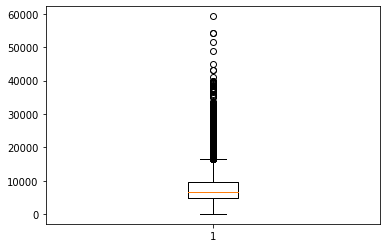

In [ ]:
#Desafio 5: Visualização para análise de quartis, mediana e outliers
plt.boxplot(dados_vendas["Valor_mqd"])
plt.show()

## 9. Price per location and monthly income
Desafios desta aula

- Tentar vincular dados do IBGE com os dados de imóveis.

- Tratar os outliers e comparar com os resultados.

- Agrupar por mais de uma categoria e realizar as análises.

- Organize o colab para deixar com cara de projeto.

In [ ]:
#1. Número de imóveis por bairro
imoveis_bairro = dados["Bairro"].value_counts()
imoveis_bairro

Alto de Pinheiros     409
Jardim Guedala        403
Jardim Paulista       309
Brooklin Paulista     247
Jardim Europa         240
                     ... 
Jardim das Imbuias      1
Vila Represa            1
Vila Nancy              1
Sítio Represa           1
Vila Invernada          1
Name: Bairro, Length: 701, dtype: int64

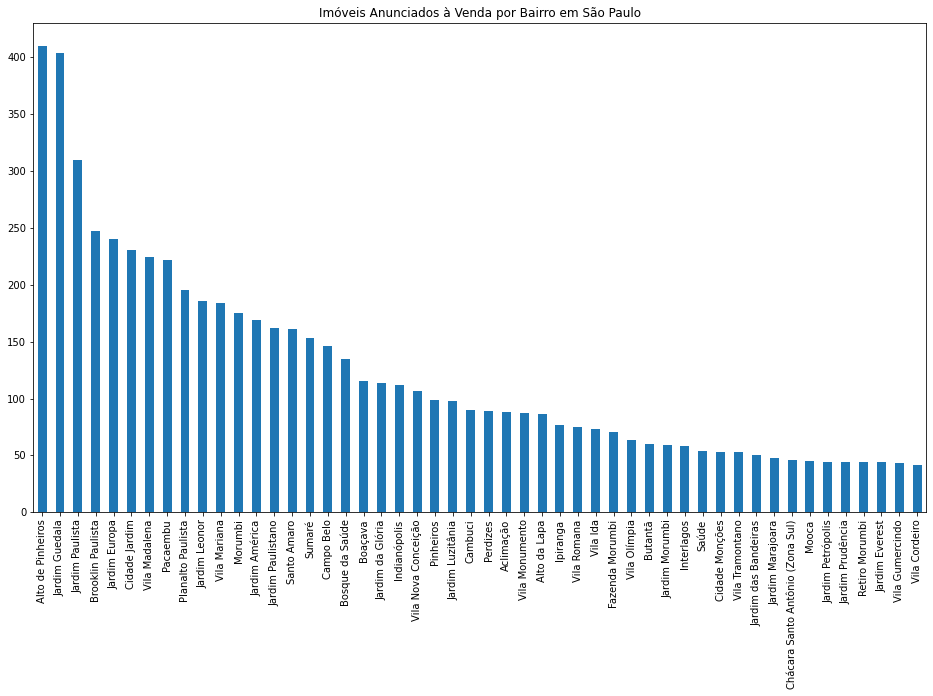

In [ ]:
#2. Gráfico de barras com número de imóveis por bairro
from matplotlib import pyplot as plt
plt.figure(figsize=(16,9))
imoveis_bairro.head(50).plot.bar(title= "Imóveis Anunciados à Venda por Bairro em São Paulo")

In [ ]:
dados_vendas["Rua"].str.extract(r'(^[\w ]+)')

,0
0,Avenida Itacira
1,Rua Aurelia Perez Alvarez
2,Rua Alba Valdez
3,NaN
4,Rua Tobias Barreto
...,...
10002,Avenida Odila
10003,Rua Tapuçu
10004,Rua Guararema
10005,Rua Estero Belaco


In [ ]:
#1. Junção da malha censitária com os dados do censo
geo_stats = geo_sp.merge(dados_ibge, on = 'CD_SETOR')
geo_stats

,CD_SETOR,NM_MUN,NM_DIST,geometry,DISTRITO,DOMICILIOS,MORADORES_SETOR,MORADORES_DOMICILIO,RENDA_MENSAL
0,355030801000001,São Paulo,Água Rasa,"POLYGON ((-46.56954 -23.56918, -46.57016 -23.5...",ÁGUA RASA,266.0,800.0,3.01,2091.32
1,355030801000002,São Paulo,Água Rasa,"POLYGON ((-46.56806 -23.56521, -46.56786 -23.5...",ÁGUA RASA,306.0,913.0,2.98,1650.09
2,355030801000003,São Paulo,Água Rasa,"POLYGON ((-46.56619 -23.56605, -46.56632 -23.5...",ÁGUA RASA,189.0,625.0,3.31,1280.43
3,355030801000004,São Paulo,Água Rasa,"POLYGON ((-46.56876 -23.56856, -46.56863 -23.5...",ÁGUA RASA,181.0,572.0,3.16,1119.59
4,355030801000005,São Paulo,Água Rasa,"POLYGON ((-46.57121 -23.57005, -46.57056 -23.5...",ÁGUA RASA,240.0,754.0,3.14,1416.90
...,...,...,...,...,...,...,...,...,...
12677,355030896000243,São Paulo,Lajeado,"POLYGON ((-46.38852 -23.54386, -46.38850 -23.5...",LAJEADO,96.0,336.0,3.50,772.09
12678,355030896000244,São Paulo,Lajeado,"POLYGON ((-46.38778 -23.54610, -46.38795 -23.5...",LAJEADO,54.0,209.0,3.87,692.50
12679,355030896000245,São Paulo,Lajeado,"POLYGON ((-46.42220 -23.52130, -46.42244 -23.5...",LAJEADO,87.0,339.0,3.90,630.06
12680,355030896000246,São Paulo,Lajeado,"POLYGON ((-46.42180 -23.52145, -46.42166 -23.5...",LAJEADO,38.0,163.0,4.29,597.37


In [ ]:
#2. Filtragem de dados redundantes
geo_stats = geo_stats.drop(['DISTRITO'], axis=1)
geo_stats

,CD_SETOR,NM_MUN,NM_DIST,geometry,DOMICILIOS,MORADORES_SETOR,MORADORES_DOMICILIO,RENDA_MENSAL
0,355030801000001,São Paulo,Água Rasa,"POLYGON ((-46.56954 -23.56918, -46.57016 -23.5...",266.0,800.0,3.01,2091.32
1,355030801000002,São Paulo,Água Rasa,"POLYGON ((-46.56806 -23.56521, -46.56786 -23.5...",306.0,913.0,2.98,1650.09
2,355030801000003,São Paulo,Água Rasa,"POLYGON ((-46.56619 -23.56605, -46.56632 -23.5...",189.0,625.0,3.31,1280.43
3,355030801000004,São Paulo,Água Rasa,"POLYGON ((-46.56876 -23.56856, -46.56863 -23.5...",181.0,572.0,3.16,1119.59
4,355030801000005,São Paulo,Água Rasa,"POLYGON ((-46.57121 -23.57005, -46.57056 -23.5...",240.0,754.0,3.14,1416.90
...,...,...,...,...,...,...,...,...
12677,355030896000243,São Paulo,Lajeado,"POLYGON ((-46.38852 -23.54386, -46.38850 -23.5...",96.0,336.0,3.50,772.09
12678,355030896000244,São Paulo,Lajeado,"POLYGON ((-46.38778 -23.54610, -46.38795 -23.5...",54.0,209.0,3.87,692.50
12679,355030896000245,São Paulo,Lajeado,"POLYGON ((-46.42220 -23.52130, -46.42244 -23.5...",87.0,339.0,3.90,630.06
12680,355030896000246,São Paulo,Lajeado,"POLYGON ((-46.42180 -23.52145, -46.42166 -23.5...",38.0,163.0,4.29,597.37


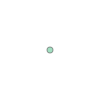

In [ ]:
#3. Importação do módulo de coordenadas espaciais
from shapely.geometry import Point
latitude = -23.56 	
longitude = -46.59
Point(longitude, latitude)

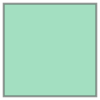

In [ ]:
#4. Importação do módulo de poligonais 
from shapely.geometry import Polygon
Polygon([[0, 0], [1, 0], [1, 1], [0, 1], [0, 0]])

In [ ]:
Polygon([[0, 0], [1, 0], [1, 1], [0, 1], [0, 0]]).contains(Point(0.1,0.9))

True

In [ ]:
cep_sp["Point"] = ""
for i in cep_sp.index:
    cep_sp["Point"][i] = Point(cep_sp["longitude"][i], cep_sp["latitude"][i])

cep_sp['setor_censo'] = cep_sp["Point"][:10].map(lambda x: geo_stats.loc[geo_stats.contains(x), 'CD_SETOR'].values).str[0]
cep_sp

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


KeyboardInterrupt: ignored

In [ ]:
cep_sp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57049 entries, 543013 to 1104360
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tipo_logr        57049 non-null  object 
 1   logr_nome        57049 non-null  object 
 2   logr_compl       57049 non-null  object 
 3   numero           41 non-null     object 
 4   bairro           57049 non-null  object 
 5   nome_localidade  57049 non-null  object 
 6   sigla_uf         57049 non-null  object 
 7   cep              57049 non-null  float64
 8   latitude         57002 non-null  float64
 9   longitude        57002 non-null  float64
 10  Point            57049 non-null  object 
 11  setor_censo      6 non-null      float64
dtypes: float64(4), object(8)
memory usage: 7.7+ MB


In [ ]:
cep_sp["Point"] = ""
for i in cep.index:
    cep["Point"][i] = Point(cep["longitude"][i], cep["latitude"][i])

cep_sp['dados_geo'] = dados_geo["Point"][:10].map(lambda x: setor_censo_sp.loc[setor_censo_sp.contains(x), 'CD_GEOCODI'].values).str[0]
dados_geo

KeyError: ignored

## 10. Price predicting model
Desafios desta aula

- Adicionar o valor "real" do m² do imóvel.

- Testar outro modelo de regressão.

- Criar um modelo baseline com as features originais.

- Trabalhar mais nos dados e criar novas variáveis.

- Testar as predições para casos reais.

- Criar um projeto com os resultados da Imersão e postar nas redes sociais mostrando o trabalho realizado.